In [1]:
import psycopg2 as pg 
import pandas as pd
import numpy as np
import random
import math
from faker import Faker

## German List Section


In [2]:
url = 'https://de.wikipedia.org/wiki/Liste_der_L%C3%A4nder_und_Territorien_nach_Einwohnerzahl'
html = pd.read_html(url)
df = max(html, key=len)
# nur staat und einwohnerzahl
df = df[['Staat', 'Einwohnerzahl (2024)']]
# welt und eu rausnehemn 
df = df[df['Staat'] != 'Welt']
df = df[df['Staat'] != 'Europäische Union']
# columns umbenenen
df.columns = ['country', 'population']
# tausender seperatoren removen
df['population'] = df['population'].str.replace('.', '') 
df['population'] = df['population'].astype(int)
# durch tausend teilen wegen einfachheit
#df['population'] = np.where(df['population'] < 1000,
#                            df['population'],
#                           df['population'].astype(int) // 1000)'
df['population'] = df['population'].apply(lambda x: math.ceil(x/1000))
# clean up country names 
df['country'] = df['country'].str.replace('\[.*?\]', '')
df['country'] = df['country'].str.strip()
df['country'] = (df['country']
                .str.replace('\[.*?\]', '', regex=True)      
                .str.replace('\xa0', ' ', regex=True)        
                .str.replace('\s+', ' ', regex=True)         
                .str.strip()) 
# reset index
df = df.reset_index(drop=True)

## Taking a look at the german list

In [3]:

daten = df
daten = daten.sort_values('population', ascending=True)
print(daten)

                 country  population
236         Vatikanstadt           1
235                 Niue           2
234              Tokelau           3
233       Falklandinseln           4
232           Montserrat           5
..                   ...         ...
4               Pakistan      251270
3             Indonesien      283488
2     Vereinigte Staaten      345427
1    Volksrepublik China     1419322
0                 Indien     1450936

[237 rows x 2 columns]


# English list section


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
html = pd.read_html(url)
df = max(html, key=len)
df = df[['Location', 'Population']]
df = df[df['Location'] != 'World']
df = df.iloc[:-2]
df.columns = ['country', 'population']
df['population'] = df['population'].astype(int)
df['population'] = df['population'].apply(lambda x: math.ceil(x/1000))
#df = df.sort_values('population', ascending=True)
df = df.reset_index(drop=True)
print(len(df))


237


### Print bar diagram

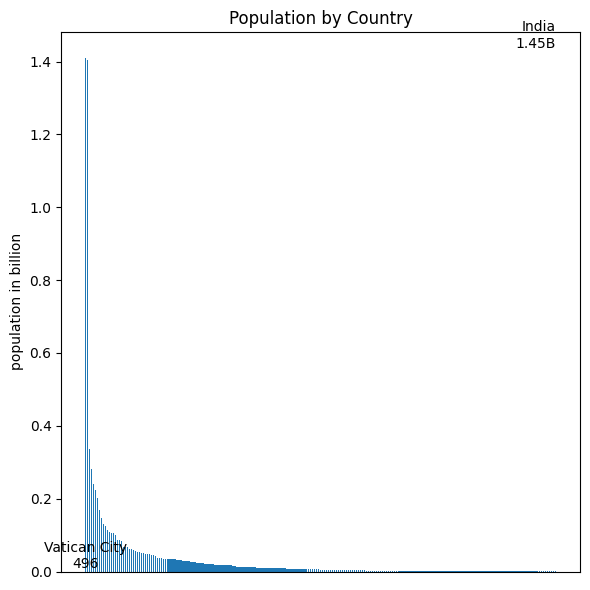

In [4]:
import matplotlib.pyplot as plt 

#assert len(countries) == len(population)
#countries = list(df['country'])
#population = list(df['population'])
countries = list(df['country'])
population = list(df['population'])
population = [(i/1000000) for i in population]

fig, ax = plt.subplots(figsize=(6,6))

bars = ax.bar(countries, population)

plt.xticks([])

ax.text(0,  # Position of India (first bar)
        0.001,  # Population value (slightly above the bar)
        f'Vatican City\n496', 
        ha='center', 
        va='bottom')

ax.text(len(countries)-1,  # Position of last bar
        1.43,  # Population value (slightly above the bar)
        f'India\n1.45B', 
        ha='right', 
        va='bottom')

ax.set_ylabel('population in billion')
ax.set_title('Population by Country')

plt.tight_layout()
plt.savefig('../../results/plots/population_chart.png', dpi=600, bbox_inches='tight')

plt.show()




### Preparing for SQL DB

In [6]:
# Iterate using itertuples()
import random

entries = []
for row in df.itertuples():
    entries.extend([row.country] * row.population)
random.shuffle(entries)
    
print(len(entries))
print(entries[0])


7945017
Botswana


In [7]:
ids = np.random.choice(range(1000000, 10000000), 
                      size=len(entries), 
                      replace=False)


print(ids[5:])
print(len(ids))
print(ids[:5])

[6149502 3842708 6200373 ... 5573992 4799252 3821729]
7945017
[7322152 2220512 9706641 3888090 3781853]


In [11]:
import src.utils.db_connector as dc
from psycopg2.extras import execute_values

print("Starting script...")

db_params = {
    "database": "countries",
    "user": "fridtjofdamm",
    "password": "",
    "host": "localhost",
    "port": "5432"
}

print("Database parameters set.")

data = list(zip(ids, entries))
print(f"Data zipped: {data[:5]}...")  # Print first 5 entries for debugging

data = [(int(id_), str(entry)) for id_, entry in zip(ids, entries)]
print(f"Data formatted: {data[:5]}...")  # Print first 5 entries for debugging

try:
    print("Connecting to the database...")
    conn = pg.connect(**db_params)
    cur = conn.cursor()
    print("Database connection established.")

    create_table_query = """
        CREATE TABLE IF NOT EXISTS users (
        id INTEGER PRIMARY KEY,
        country VARCHAR(255) NOT NULL
        );
    """
    print("Executing create table query...")
    cur.execute(create_table_query)
    print("Create table query executed.")

    query = """
        INSERT INTO users (id, country)
        VALUES %s
    """
    print("Inserting data into the table...")
    execute_values(cur, query, data)
    conn.commit()
    print("Data inserted and committed.")

except Exception as e:
    print(f"Error: {e}")
    conn.rollback()
    print("Transaction rolled back.")

finally:
    if cur:
        cur.close()
        print("Cursor closed.")
    if conn:
        conn.close()
        print("Connection closed.")

print("Script finished.")

Starting script...
Database parameters set.
Data zipped: [(7322152, 'Botswana'), (2220512, 'France'), (9706641, 'India'), (3888090, 'Colombia'), (3781853, 'Burkina Faso')]...
Data formatted: [(7322152, 'Botswana'), (2220512, 'France'), (9706641, 'India'), (3888090, 'Colombia'), (3781853, 'Burkina Faso')]...
Connecting to the database...
Database connection established.
Executing create table query...
Create table query executed.
Inserting data into the table...
Data inserted and committed.
Cursor closed.
Connection closed.
Script finished.


In [ ]:
import json
# india vs vatican city examle
test_countries = ["Vatikanstadt", "Indien"]

db_params = {
    "dbname": "countries",
    "user": "fridtjofdamm",
    "password": "",
    "host": "localhost",
    "port": "5432"
}


conn = pg.connect(**db_params)
cur = conn.cursor()
print(type(cur))


query = """
    EXPLAIN (FORMAT JSON, ANALYZE) 
    SELECT id, country 
    FROM users 
    WHERE country = %s;
"""
try:
    for country in test_countries:
        cur.execute(query, (country,))
        res = cur.fetchall()
        with open(f'resources/query_examples/qplans_country_example/{country}.json', encoding='utf-8', mode='w') as f:
            json.dump(res, f)

except psycopg2.Error as err:
    conn.rollback()
    raise err
finally:
    cur.close()
    conn.close()

print(res)


<class 'psycopg2.extensions.cursor'>


NameError: name 'psycopg2' is not defined